In [64]:
from google.colab import drive
drive.mount('/content.gdrive')

Drive already mounted at /content.gdrive; to attempt to forcibly remount, call drive.mount("/content.gdrive", force_remount=True).


In [65]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
#from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [66]:
url="/content.gdrive/My Drive/service_record.csv"
mileageService=pd.read_csv(url)
mileageService.head()

,slno,vehicle_type,brand,model,engine_type,make_year,region,mileage_range,mileage,oil_filter,...,air_clean_filter,fuel_filter,spark_plug,brake_fluid,brake_and_clutch_oil,transmission_fluid,brake_pads,clutch,coolant,cost
0,1,car,honda,jazz,petrol,2017,chennai,10000,11400,1,...,0,0,0,0,0,0,0,0,0,2566
1,2,car,honda,jazz,petrol,2017,chennai,10000,11453,1,...,0,0,0,0,0,0,0,0,0,2633
2,3,car,honda,jazz,petrol,2017,chennai,10000,10706,1,...,0,0,0,0,0,0,0,0,0,2643
3,4,car,honda,jazz,petrol,2017,chennai,10000,11015,1,...,0,0,0,0,0,0,0,0,0,2532
4,5,car,honda,jazz,petrol,2017,chennai,10000,10039,1,...,0,0,0,0,0,0,0,0,0,2489


In [67]:
#mileageService['mileage'] = mileageService['mileage'].astype(str)
mileageService.dtypes

slno                              int64
vehicle_type                     object
brand                            object
model                            object
engine_type                      object
make_year                         int64
region                           object
mileage_range                     int64
mileage                           int64
oil_filter                        int64
engine_oil                        int64
washer_plug_drain                 int64
dust_and_pollen_filter            int64
whell_alignment_and_balancing     int64
air_clean_filter                  int64
fuel_filter                       int64
spark_plug                        int64
brake_fluid                       int64
brake_and_clutch_oil              int64
transmission_fluid                int64
brake_pads                        int64
clutch                            int64
coolant                           int64
cost                              int64
dtype: object

In [68]:
train,test = train_test_split(mileageService,test_size=0.2)
train,val = train_test_split(train,test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

728 train examples
183 validation examples
228 test examples


In [69]:
mileageService_features = train.copy()
mileageService_labels = mileageService_features.pop('mileage')
mileageService_labels = mileageService_labels/100000

val_features = val.copy()
val_labels = val.pop('mileage')
val_labels = val_labels/100000

In [70]:
print(mileageService_features.dtypes)
print(mileageService_labels.dtypes)

slno                              int64
vehicle_type                     object
brand                            object
model                            object
engine_type                      object
make_year                         int64
region                           object
mileage_range                     int64
oil_filter                        int64
engine_oil                        int64
washer_plug_drain                 int64
dust_and_pollen_filter            int64
whell_alignment_and_balancing     int64
air_clean_filter                  int64
fuel_filter                       int64
spark_plug                        int64
brake_fluid                       int64
brake_and_clutch_oil              int64
transmission_fluid                int64
brake_pads                        int64
clutch                            int64
coolant                           int64
cost                              int64
dtype: object
float64


In [71]:
inputs = {}

for name, column in mileageService_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs


{'slno': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'slno')>,
 'vehicle_type': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'vehicle_type')>,
 'brand': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'brand')>,
 'model': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'model')>,
 'engine_type': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'engine_type')>,
 'make_year': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'make_year')>,
 'region': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'region')>,
 'mileage_range': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'mileage_range')>,
 'oil_filter': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'oil_filter')>,
 'engine_oil': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'engine_oil')>,
 'washer_plug_drain': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'washer_plug_drain')>

In [72]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(mileageService[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 18) dtype=float32 (created by layer 'normalization_1')>

In [73]:
preprocessed_inputs = [all_numeric_inputs]

In [74]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  
  lookup = preprocessing.StringLookup(vocabulary=np.unique(mileageService_features[name]))
  one_hot = preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

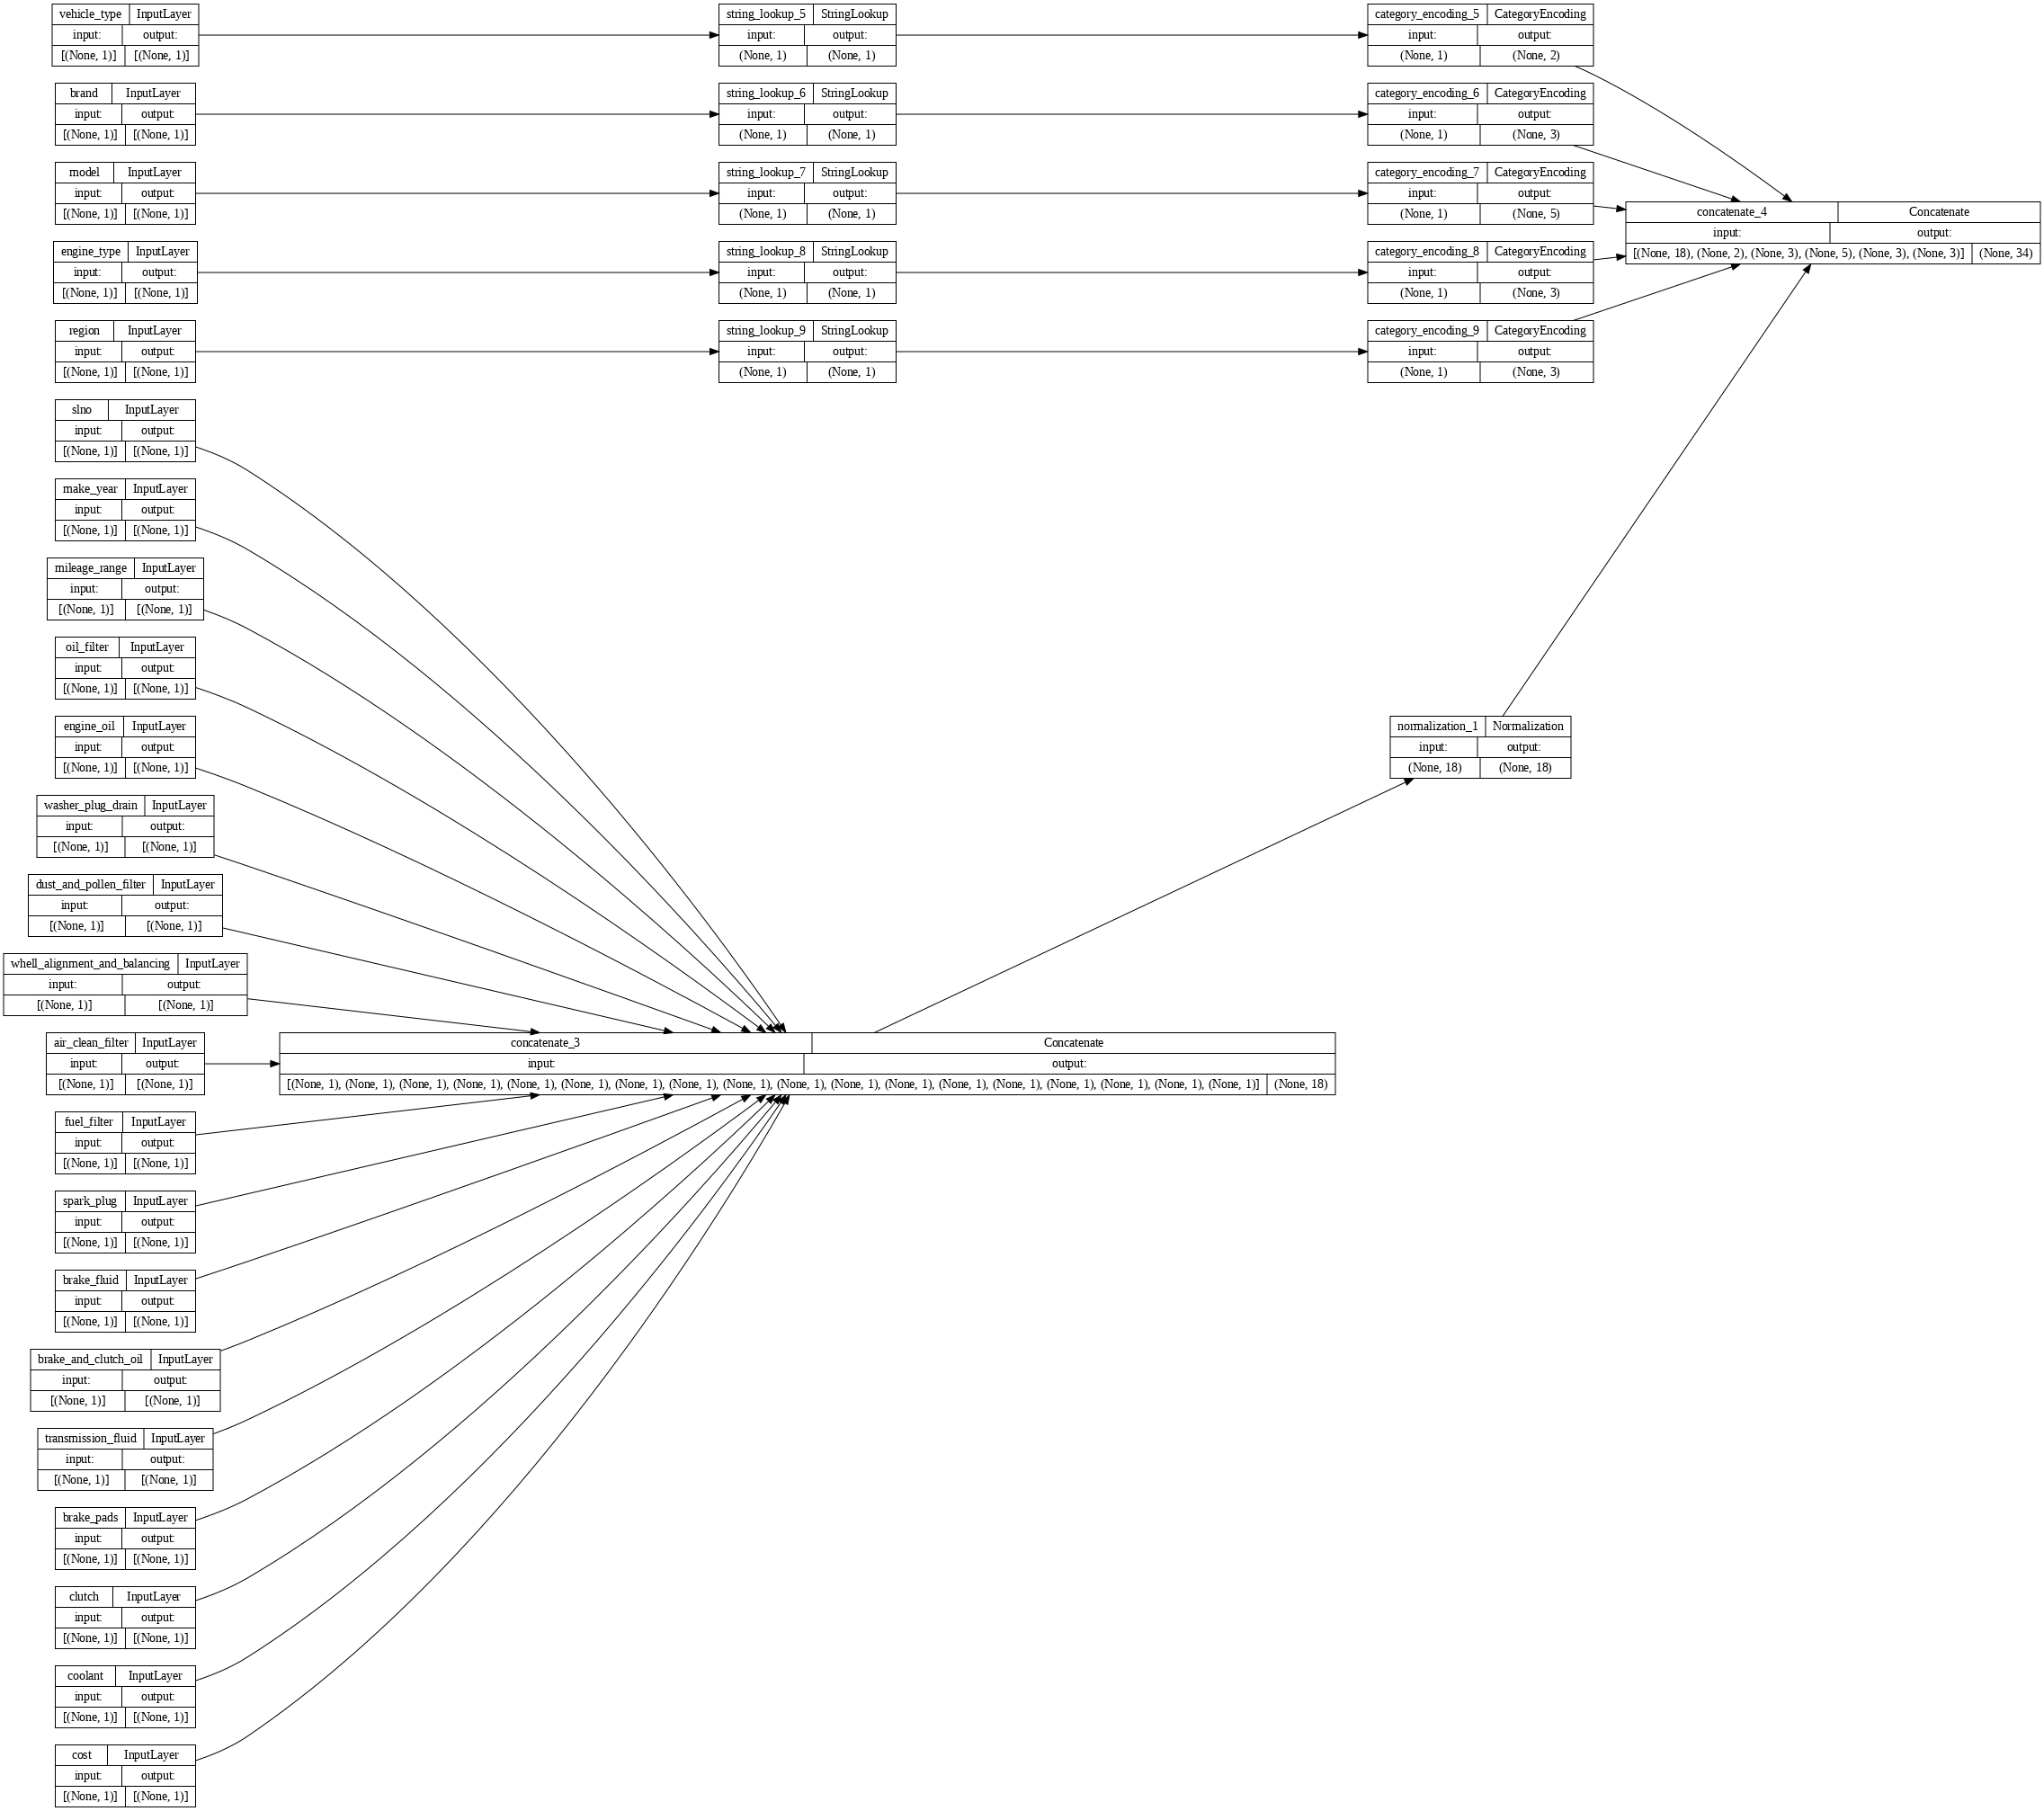

In [75]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

mileageService_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat,name="Ioan")

tf.keras.utils.plot_model(model = mileageService_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

In [76]:
mileageService_features_dict = {name: np.array(value) 
                         for name, value in mileageService_features.items()}

In [77]:
features_dict = {name:values[:1] for name, values in mileageService_features_dict.items()}
mileageService_preprocessing(features_dict)

<tf.Tensor: shape=(1, 34), dtype=float32, numpy=
array([[-0.684,  1.164, -1.028,  0.   ,  0.   ,  0.367, -0.622, -0.591,
         1.27 , -0.635, -0.26 , -0.423, -0.394, -0.407, -0.406, -0.391,
        -0.242, -0.562,  0.   ,  1.   ,  0.   ,  1.   ,  0.   ,  0.   ,
         1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,
         1.   ,  0.   ]], dtype=float32)>

In [78]:
def mileageService_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(64,activation='relu'),
    #layers.Dense(64,activation='relu'),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  newmod = tf.keras.Model(inputs, result,name="vasilica")

  newmod.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return newmod

mileageService_model = mileageService_model(mileageService_preprocessing, inputs)

In [79]:
val_features_dict = {name: np.array(value) 
                         for name, value in val.items()}
history_1 = mileageService_model.fit(x=mileageService_features_dict, y=mileageService_labels,epochs=250,
                        validation_data=(val_features_dict, val_labels))

Epoch 1/250
23/23 [==============================] - 2s 28ms/step - loss: 0.2082 - mae: 0.2898 - val_loss: 0.0926 - val_mae: 0.1699
Epoch 2/250
23/23 [==============================] - 0s 6ms/step - loss: 0.0648 - mae: 0.1009 - val_loss: 0.0543 - val_mae: 0.0662
Epoch 3/250
23/23 [==============================] - 0s 8ms/step - loss: 0.0493 - mae: 0.0510 - val_loss: 0.0474 - val_mae: 0.0478
Epoch 4/250
23/23 [==============================] - 0s 7ms/step - loss: 0.0449 - mae: 0.0374 - val_loss: 0.0437 - val_mae: 0.0366
Epoch 5/250
23/23 [==============================] - 0s 7ms/step - loss: 0.0420 - mae: 0.0290 - val_loss: 0.0412 - val_mae: 0.0289
Epoch 6/250
23/23 [==============================] - 0s 7ms/step - loss: 0.0399 - mae: 0.0232 - val_loss: 0.0396 - val_mae: 0.0259
Epoch 7/250
23/23 [==============================] - 0s 7ms/step - loss: 0.0383 - mae: 0.0212 - val_loss: 0.0381 - val_mae: 0.0252
Epoch 8/250
23/23 [==============================] - 0s 7ms/step - loss: 0.0368 - 

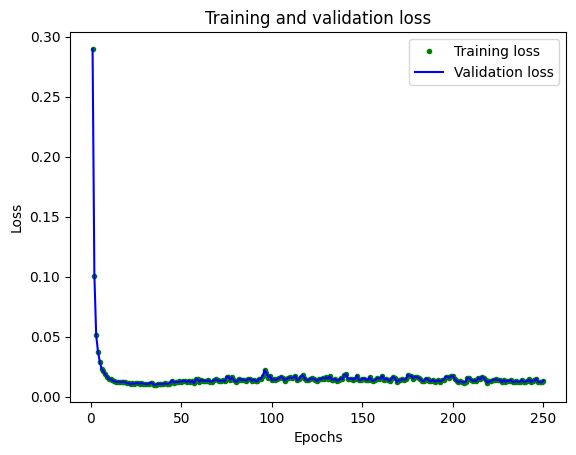

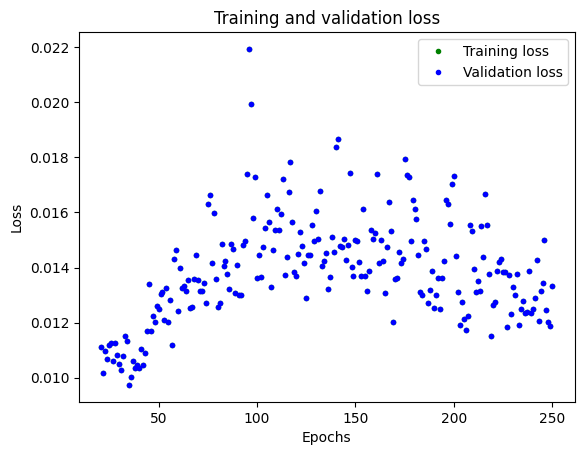

In [80]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
import matplotlib.pyplot as plt
train_loss = history_1.history['mae']
val_loss = history_1.history['mae']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 20

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [81]:
mileageService_model.save('test')
reloaded = tf.keras.models.load_model('test')

In [82]:
! zip -r test.zip test

updating: test/ (stored 0%)
updating: test/keras_metadata.pb (deflated 95%)
updating: test/assets/ (stored 0%)
updating: test/fingerprint.pb (stored 0%)
updating: test/variables/ (stored 0%)
updating: test/variables/variables.index (deflated 61%)
updating: test/variables/variables.data-00000-of-00001 (deflated 11%)
updating: test/saved_model.pb (deflated 89%)


In [83]:
features_dict = {name:values[:1] for name, values in mileageService_features_dict.items()}

before = mileageService_model(features_dict)
after = reloaded(features_dict)
assert (before-after)<1e-3
print(before)
print(after)

tf.Tensor([[0.209]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.209]], shape=(1, 1), dtype=float32)


In [84]:
testing = {
    'slno': np.array([1, 2]),
    'vehicle_type': np.array(['car','car']),
    'brand': np.array(['honda','honda']),
    'model': np.array(['jazz','jazz']),
    'engine_type': np.array(['petrol','diesel']),
    "make_year": np.array([2016,2018]),
    'region': np.array(['chennai','chennai']),
    'mileage_range': np.array([10000,10000]),
    'oil_filter': np.array([1,0]),
    'engine_oil': np.array([1,0]),
    'washer_plug_drain': np.array([1,0]),
    'dust_and_pollen_filter': np.array([1,0]),
    'whell_alignment_and_balancing':np.array([1,0]),
    "air_clean_filter": np.array([1,0]),
    "fuel_filter": np.array([1,0]),
    "spark_plug": np.array([1,0]),
    "brake_fluid": np.array([1,0]),
    "brake_and_clutch_oil": np.array([1,0]),
    "transmission_fluid": np.array([1,0]),
    "brake_pads": np.array([1,0]),
    "clutch": np.array([1,0]),
    "coolant": np.array([1,0]),
    "cost": np.array([3000,2500]) 
}

In [86]:
ans = reloaded.predict(testing)
print(ans*10000)

1/1 [==============================] - 0s 42ms/step
[[2249.653]
 [1303.203]]
